In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from comparison import ForecastToObsAlignment, Comparison

### Checking the constructed observations

In [67]:
basepath = Path('/nobackup/users/straaten/ERA5/')
hotpath = basepath / 'tg-ex-q0.75-4D_1998-06-07_2019-08-31_1D_15-t2m-q095-adapted-mean.nc'
clusterpath = basepath / 'tg-anom_2000-01-01_2000-02-01_1D_15-t2m-q095-adapted-mean.nc'

In [68]:
clusters = xr.open_dataset(clusterpath)['clustidfield']

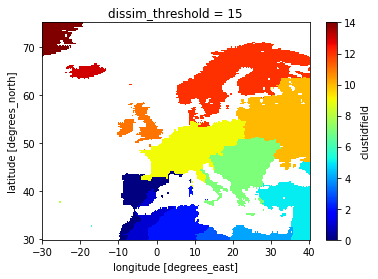

In [69]:
clusters.plot(cmap = 'jet')

cluster 6 and 8 are almost gridpoints.

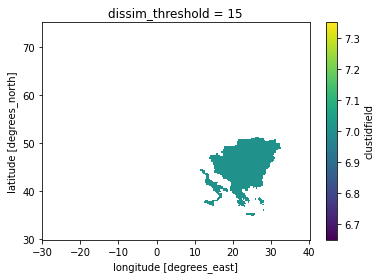

In [100]:
clusters.where(clusters == 7, np.nan).plot()

In [32]:
da = xr.open_dataarray(hotpath)

In [33]:
df = da.to_dataframe().unstack(-1)

array([[<AxesSubplot:title={'center':"('tg-ex-q0.75-4D', 10)"}>,
        <AxesSubplot:title={'center':"('tg-ex-q0.75-4D', 12)"}>],
       [<AxesSubplot:title={'center':"('tg-ex-q0.75-4D', 14)"}>,
        <AxesSubplot:>]], dtype=object)

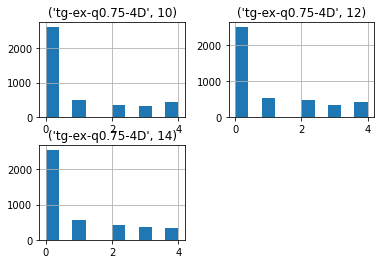

In [16]:
df.loc[slice(None,'2010-01-01'),(slice(None),[10,12,14])].hist()

<AxesSubplot:title={'center':'frequency of 4 day episodes per year'}, xlabel='time'>

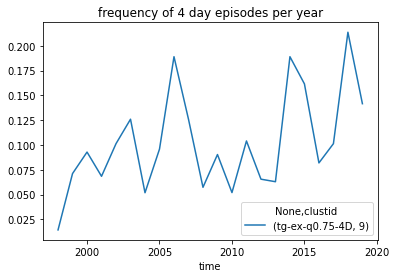

In [43]:
(df.loc[:,(slice(None),9)] == 4).groupby(df.index.year).apply(lambda d: d.sum()/d.count()).plot(title = 'frequency of 4 day episodes per year')

<AxesSubplot:title={'center':'amount of 0 day episodes per year'}, xlabel='time'>

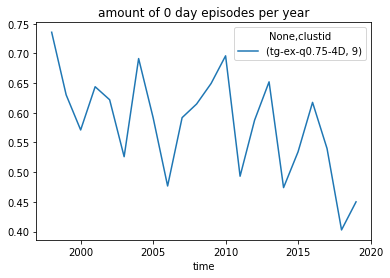

In [42]:
(df.loc[:,(slice(None),9)] == 0).groupby(df.index.year).apply(lambda d: d.sum()/d.count()).plot(title = 'frequency of 0 day episodes per year')

Trending behaviour is as expected. As temperatures rise (and we have a fixed quantile threshold in time) it will happen more often. So less non-occurrences, more chance of multiple occurrences (supposing probabilities are independent day-to-day). Noisy of course, and the first and last years are incomplete.

Quantile dependence on season should show that distribution is equal over the year.

<AxesSubplot:xlabel='time'>

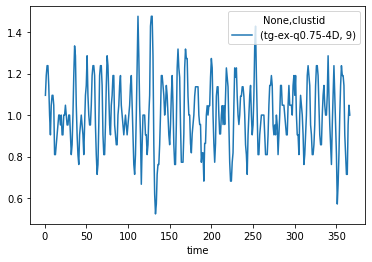

In [50]:
df.loc[:,(slice(None),9)].groupby(df.index.day_of_year).mean().plot()

### Checking a 7day match
this variable has 7 options. What would be a good categorical split? Perhaps first binary, like >= 3

In [3]:
bookfile = 'books_paper3-2_tg-ex-q0.75-7D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv'

In [5]:
al = ForecastToObsAlignment('JJA','45r1')
al.recollect(booksname = bookfile)
df = al.alignedobject.compute()

In [14]:
df

time clustid leadtime forecast                                \
number                                    0    1    2    3    4    5    6   
0      1998-06-07       0        1      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      1998-06-07       1        1      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      1998-06-07       2        1      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      1998-06-07       3        1      0.0  1.0  0.0  1.0  0.0  0.0  0.0   
4      1998-06-07       4        1      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..            ...     ...      ...      ...  ...  ...  ...  ...  ...  ...   
10     2019-06-24      10       40      7.0  2.0  7.0  1.0  3.0  0.0  7.0   
11     2019-06-24      11       40      0.0  0.0  3.0  6.0  0.0  0.0  0.0   
12     2019-06-24      12       40      4.0  1.0  4.0  5.0  0.0  2.0  2.0   
13     2019-06-24      13       40      0.0  2.0  0.0  3.0  0.0  7.0  2.0   
14     2019-06-24      14       40      0.0  7.0  0.0  0.0  2.0  5.0  0.0   

                           observation  
number    7    8    9   10           0  
0       0.0  0.0  0.0  0.0         1.0  
1       0.0  0.0  0.0  1.0         2.0  
2       0.0  0.0  0.0  0.0         0.0  
3       0.0  1.0  0.0  1.0         1.0  
4       0.0  0.0  0.0  0.0         4.0  
..      ...  ...  ...  ...         ...  
10      7.0  0.0  0.0  6.0         0.0  
11      1.0  0.0  1.0  1.0         4.0  
12      0.0  0.0  2.0  0.0         0.0  
13      1.0  2.0  1.0  0.0         5.0  
14      0.0  0.0  0.0  0.0         4.0  

[273420 rows x 15 columns]

<AxesSubplot:>

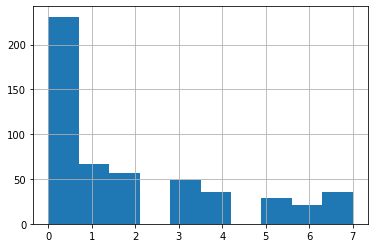

In [12]:
df.loc[np.logical_and(df['clustid'] == 9, df['leadtime'] == 1),('forecast',0)].hist()

<AxesSubplot:>

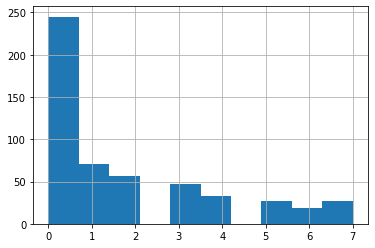

In [13]:
df.loc[np.logical_and(df['clustid'] == 9, df['leadtime'] == 1),('forecast',1)].hist()

In [89]:
 # days > q0.75 within 7 
def transform_and_bs(frame: pd.DataFrame, nday_threshold: int = 3):
    """
    A computed aligned frame. returns it with a pi, pi_bs and clim_bs column. 
    Pi is for positive case so chance of >= nday_threshold
    """
    test = frame.copy()
    test['pi'] = (test['forecast'].values >= nday_threshold).sum(axis = 1) / test['forecast'].shape[-1]
    test['observation'] = test['observation'].values >= nday_threshold
    clim_chances = test.groupby('clustid').mean()['observation'] # Assume there is little leadtime dependence (pooling these for a smoother estimate)
    clim_chances.columns = pd.MultiIndex.from_tuples([('climatology','')])
    test = test.merge(clim_chances, on = 'clustid')
    for key in ['pi','climatology']:
        bs = (test[key].values.squeeze() - test['observation'].values.squeeze())**2
        scorename = f'{key}_bs'
        test[scorename] = bs
    test['bss'] = 1 - test['pi_bs']/test['climatology_bs']
    return test

In [94]:
test = transform_and_bs(df)
test = test.groupby(['clustid','leadtime']).mean().unstack(0) # column levels are e.g. obs, member, clustid

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<AxesSubplot:xlabel='leadtime'>

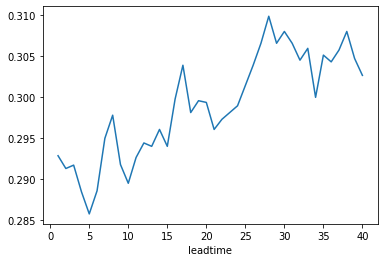

In [95]:
test.loc[:,('pi','',11)].plot() # Interestingly cluster 11 has a drift to more frequent occurrence.

<AxesSubplot:xlabel='leadtime'>

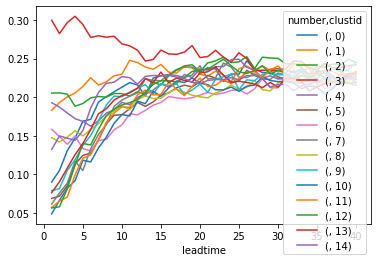

In [96]:
test['pi_bs'].plot()

<AxesSubplot:xlabel='leadtime'>

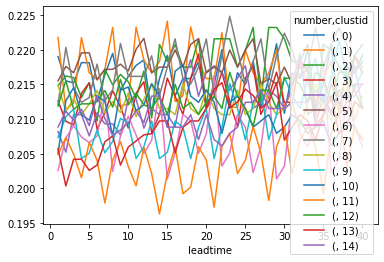

In [97]:
test['climatology_bs'].plot()

When normalized I think that all regions go to negative skill at the final lead times. This probably has to do with the fact that drift in spread is not corrected for (would require leadtime dependent quantile climatology).

Also interesting is the clusters 6 and 8, with an initial increase in skill with lead time. When checking the clusterarray it appeared that these clusters are ... almost as small as gridpoints. Interesting is also that skill for 10 (great brittain) > skill for 9 (west and central europe).

<AxesSubplot:xlabel='leadtime'>

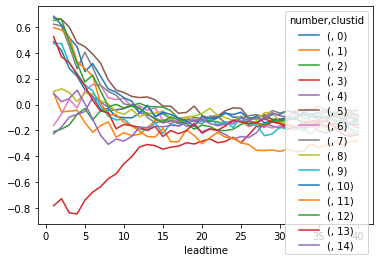

In [98]:
test['bss'].plot()

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
 

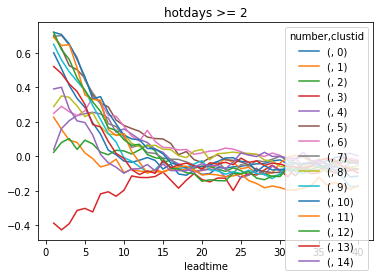

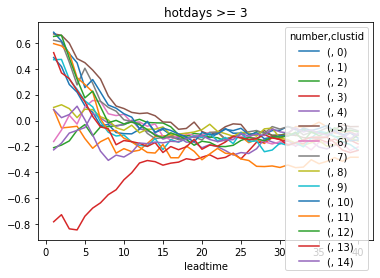

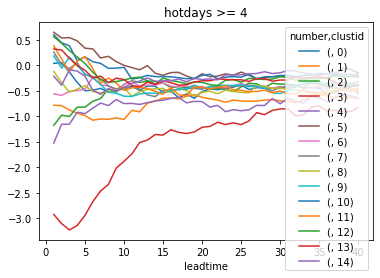

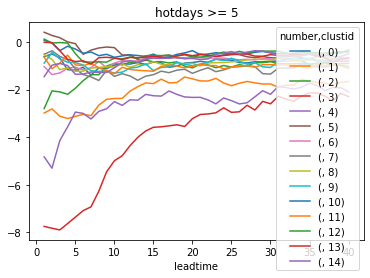

In [102]:
for threshold in [2,3,4,5]:
    test = transform_and_bs(df,nday_threshold=threshold)
    test = test.groupby(['clustid','leadtime']).mean().unstack(0)
    test['bss'].plot(title = f'hotdays >= {threshold}')

More than 2 hotdays is already a less frequent part of the data. Skill is present and compares with the first paper estimates. Leadtime here is not untill midpoint but till the first day.

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<AxesSubplot:xlabel='time'>

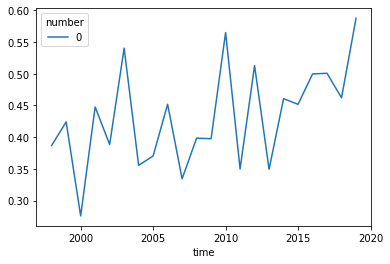

In [109]:
temp = transform_and_bs(df,nday_threshold=2)
temp['observation'].groupby(temp['time'].dt.year).mean().plot()